# Imports

In [1]:
config = {
    'dhdt': {
        'depth': 4,
        'learning_rate': 0.01,#1e-3,
        
        'initializer': 'Zeros', #GlorotUniform
        'initializer_index': 'Zeros', #GlorotUniform
        
        
        'loss': 'binary_crossentropy',#'mae',
        'optimizer': 'adam',        
        
        'beta_1': 10,
        'beta_2': 10,
        
        'sparse_activation_1': 'entmax', #softmax, entmax, sparsemax 
        'sparse_activation_2': 'entmax', #sigmoid, entmax, sparsemax 
        
        'activation': 'tanh', #sigmoid
        'squeeze_factor': 1,
        
        'batch_size': 512,
        'epochs': 10_000,
        'early_stopping_epochs': 50,
    },
    
    
    
    'make_classification': {
        'number_of_variables': 10,
        'n_samples': 5_000,
        'num_eval': 10,
        
        'noise': 0.2,
    },

    'computation': {
        'random_seed': 42,
        'trials': 3,
        'n_jobs': 60,
        'verbosity': 0,
    },
}



In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_updated import *
from utilities.DHDT_updated import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

# Evaluation

## make_classification

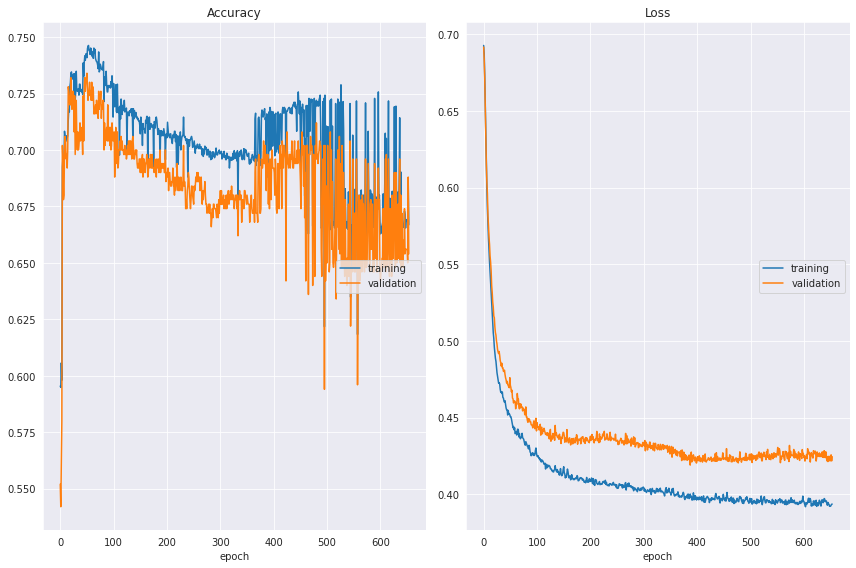

Accuracy
	training         	 (min:    0.595, max:    0.746, cur:    0.667)
	validation       	 (min:    0.542, max:    0.734, cur:    0.654)
Loss
	training         	 (min:    0.392, max:    0.693, cur:    0.394)
	validation       	 (min:    0.419, max:    0.692, cur:    0.425)
Test accuracy Sklearn (0) 0.699
Test accuracy DHDT (0) 0.662
________________________________________________________________________________________________________
Test f1 Sklearn (0) 0.6848167539267015
Test f1 DHDT (0) 0.6712062256809339
________________________________________________________________________________________________________


In [3]:
if True:
    tf.random.set_seed(config['computation']['random_seed'])
    np.random.seed(config['computation']['random_seed'])
    random.seed(config['computation']['random_seed'])  
    
    metrics = ['accuracy', 'f1']
    
    config_test = deepcopy(config)
    #config_test['make_classification']['n_samples'] = 10_000
    #config_test['dhdt']['epochs'] = 5
    #config_test['dhdt']['initializer_index'] = 'he_normal'#'ones', #GlorotUniform
    #config_test['dhdt']['activation'] = 'sigmoid'

    dataset_dict = {}
    model_dict = {}

    scores_dict = {'sklearn': {},
                   'DHDT': {}}
    
    dataset_dict = get_preprocessed_dataset('make_classification',
                                            random_seed=config_test['computation']['random_seed'],
                                            config=config_test['make_classification'],
                                            verbosity=2)

    model_dict['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                   random_state=config_test['computation']['random_seed'])

    model_dict['sklearn'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'])



    model_dict['DHDT'] = DHDT(dataset_dict['X_train'].shape[1],

                                depth = config_test['dhdt']['depth'],

                                learning_rate = config_test['dhdt']['learning_rate'],
                                optimizer = config_test['dhdt']['optimizer'],
                              
                                initializer = config_test['dhdt']['initializer'],
                                initializer_index = config_test['dhdt']['initializer_index'],
                              
                                beta_1 = config_test['dhdt']['beta_1'],
                                beta_2 = config_test['dhdt']['beta_2'],

                                activation = config_test['dhdt']['activation'],
                                squeeze_factor = config_test['dhdt']['squeeze_factor'],

                                loss = config_test['dhdt']['loss'],#'mae',

                                random_seed = config_test['computation']['random_seed'],
                                verbosity = 1)#5        


    scores_dict['history'] = model_dict['DHDT'].fit(dataset_dict['X_train'], 
                                                  dataset_dict['y_train'], 
                                                  batch_size=config_test['dhdt']['batch_size'], 
                                                  epochs=config_test['dhdt']['epochs'], 
                                                  early_stopping_epochs=config_test['dhdt']['early_stopping_epochs'], 
                                                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


    dataset_dict['y_test_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_valid'])

    dataset_dict['y_test_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_valid'])     
    
    for metric in metrics:
        
        if metric in ['accuracy', 'f1']:
            y_test_dhdt = np.round(dataset_dict['y_test_dhdt'])
            y_valid_dhdt = np.round(dataset_dict['y_valid_dhdt'])
            y_test_sklearn = np.round(dataset_dict['y_test_sklearn'])
            y_valid_sklearn = np.round(dataset_dict['y_valid_sklearn'])         
        else:
            y_test_dhdt = dataset_dict['y_test_dhdt']
            y_valid_dhdt = dataset_dict['y_valid_dhdt']
            y_test_sklearn = dataset_dict['y_test_sklearn']
            y_valid_sklearn =    dataset_dict['y_valid_sklearn']                
        
        scores_dict['sklearn'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_sklearn)
        scores_dict['DHDT'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_dhdt)

        scores_dict['sklearn'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_sklearn)   
        scores_dict['DHDT'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_dhdt)

        print('Test ' + metric + ' Sklearn (' + str(0) + ')', scores_dict['sklearn'][metric + '_test'])
        print('Test ' + metric + ' DHDT (' + str(0) + ')', scores_dict['DHDT'][metric + '_test'])   
        print('________________________________________________________________________________________________________')   


In [4]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot()
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [5]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [6]:
if False:
    parallel_eval_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                                random_seed_data = config['computation']['random_seed']+index,
                                                                                                random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                                config = config,
                                                                                                verbosity = -1) for index in range(config['make_classification']['num_eval']))

    for i, synthetic_result in enumerate(evaluation_results_synthetic):
        if i == 0:
            model_dict_synthetic = synthetic_result[0]
            scores_dict_synthetic = synthetic_result[1]
            dataset_dict_synthetic = synthetic_result[2]
        else: 
            model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
            scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
            dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])        
    
    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = [i for i in range(config['make_classification']['num_eval'])]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])

    scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)    
        
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:].index]
    mean_result_dataframe_synthetic = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_synthetic.mean()[:scores_dataframe_synthetic.shape[1]//2], scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)

        
    display(scores_dataframe_synthetic.head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[0::3]].iloc[:,[0,2,1,3]].head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]].iloc[:,[0,2,1,3]].head(5))
    display(mean_result_dataframe_synthetic)
    

In [7]:
if False:
    plot_index = 0
    
    plt.figure(figsize=(15,8))
    image = model_dict_synthetic[1]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_synthetic[1]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_synthetic[1]['sklearn'][plot_index], fontsize=10) 
    plt.show()

## Real-World Eval

In [8]:
if False:

    identifier_list = [
                        'Adult',#: 32,
                        'Bank Marketing',#: 32,
                        'Loan Credit',#: 32,

                        'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        'Loan House',#: 15,
                        'Cervical Cancer',#: 15,

                        'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]
    
    parallel_eval_real_world = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=identifier_list, 
                                                                                                   random_seed_model=config['computation']['random_seed']+i,
                                                                                                   config = config,
                                                                                                   verbosity = -1) for i in range(config['computation']['trials']))


    for i, real_world_result in enumerate(evaluation_results_real_world):
        if i == 0:
            model_dict_real_world = real_world_result[0]
            scores_dict_real_world = real_world_result[1]
            dataset_dict_real_world = real_world_result[2]
        else: 
            model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
            scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
            dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])    

    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = identifier_list
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metric + metric_identifer] for identifier in identifier_list]

        scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metric + metric_identifer] for identifier in identifier_list]    

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])
            
    scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
            
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:].index]
    mean_result_dataframe_real_world = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_real_world.mean()[:scores_dataframe_real_world.shape[1]//2], scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)
                
    display(scores_dataframe_real_world)
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[0::3]].iloc[:,[0,2,1,3]])    
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]].iloc[:,[0,2,1,3]])    

    display(mean_result_dataframe_real_world)
    


In [9]:
if False:
    plot_index = 0
    
    identifier = identifier_list[0]#"Absenteeism"
    plt.figure(figsize=(15,8))
    image = model_dict_real_world[identifier]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_real_world[identifier]['sklearn'][plot_index], fontsize=10) 
    plt.show()

# Hyperparameter Optimization

In [10]:
parameter_dict = {
        'depth': [config['dhdt']['depth']],
        'learning_rate': [0.01], #[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        
        'loss': ['binary_crossentropy'], #['binary_crossentropy', 'rmse'], #'mae',
        'optimizer': ['adam'], #['adam', 'sgd', 'rmsprop'],        
        
        'initializer': ['Zeros'],#'GlorotUniform', 'GlorotNormal',  #['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform'], #RandomNormal, RandomUniform
        'initializer_index': ['Zeros'],#['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'Zeros', 'Ones'], #RandomNormal, RandomUniform

        'beta_1': [1, 5, 10, 20, 50], #[10, 50, 100],
        'beta_2': [1, 5, 10, 20], #[10, 50, 100],
    
        'sparse_activation_1': ['softmax', 'entmax', 'sparsemax'], #softmax, entmax, sparsemax 
        'sparse_activation_2': ['sigmoid', 'entmax', 'sparsemax'], #sigmoid, entmax, sparsemax     
        
        'activation': ['tanh', 'sigmoid'], #'sigmoid'
        'squeeze_factor': [1],#[0.2, 0.5, 1, 2, 5], #[0.2, 0.5, 1, 2, 5],    
}

parameter_grid = ParameterGrid(parameter_dict)

In [11]:
if True:   
    print('Number of Trials: ' + str(len(parameter_grid)))
    
    parallel_hpo_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_hpo_synthetic = parallel_hpo_synthetic(delayed(evaluate_parameter_setting_synthetic)(parameter_setting, config, metrics= ['accuracy', 'f1']) for parameter_setting in parameter_grid)

    comparator_metric = 'f1'

    dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

    dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
    dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, dhdt_max_mean_list), reverse=True)]

    sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, sklearn_mean_list), reverse=True)]

    parameter_setting_list_unsorted = [evaluation_results_hpo_synthetic[i][1] for i in range(len(parameter_grid))]
    parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, parameter_setting_list), reverse=True)]

    hpo_results_synthetic = []
    for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
        result_dict = {
                             'DHDT mean (mean)': dhdt_mean,
                             'DHDT max (mean)': dhdt_max_mean,
                             'sklearn mean': sklearn_mean,
                             'parameters': parameter_setting
                            }

        hpo_results_synthetic.append(result_dict)

    display(hpo_results_synthetic[:5])

Number of Trials: 360


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed: 22.5min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed: 90.2min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 182.8min finished


[{'DHDT mean (mean)': 0.7395138702678692,
  'DHDT max (mean)': 0.7745321118701681,
  'sklearn mean': 0.7349388061960895,
  'parameters': {'activation': 'tanh',
   'beta_1': 50,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'entmax',
   'sparse_activation_2': 'sparsemax',
   'squeeze_factor': 1}},
 {'DHDT mean (mean)': 0.7388034179499955,
  'DHDT max (mean)': 0.7796723210492558,
  'sklearn mean': 0.7357244024077867,
  'parameters': {'activation': 'tanh',
   'beta_1': 50,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'entmax',
   'sparse_activation_2': 'entmax',
   'squeeze_factor': 1}},
 {'DHDT mean (mean)': 0.7371374141032959,
  'DHDT max (mean)': 0.7652413048417411,
  'sklearn mea

In [12]:
if True:
    identifier_list = [
                        #'Adult',#: 32,
                        #'Bank Marketing',#: 32,
                        #'Loan Credit',#: 32,

                        #'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        ##'Loan House',#: 15, 
                        'Cervical Cancer',#: 15,

                        ##'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        #'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]

    hpo_results_real_world = {}
    hpo_results_real_world_unsorted = {}
    
    print('Number of Trials: ' + str(len(parameter_grid)))
    
    print('___________________________________________________________________________')
    
    for identifier in identifier_list:
        print(identifier)
        
        dataset_dict = get_preprocessed_dataset(identifier,
                                                random_seed=config['computation']['random_seed'],
                                                config=config['make_classification'],
                                                verbosity=0)  

        base_model = DecisionTreeClassifier()

        parameter_dict_sklearn = {
                'max_depth': [config['dhdt']['depth']],
                'random_state': [config['computation']['random_seed']],
                'criterion': ['gini', 'entropy', 'log_loss'], 
                'min_samples_split': [0, 2, 5, 10, 50], 
                'min_samples_leaf': [0, 2, 5, 10, 50], 
                #'min_weight_fraction_leaf': [0.0, 0.1, 0.5, 0.8], 
                'max_features': ['auto', 'sqrt', 'log2', None], 
                #'max_leaf_nodes': [0,1,2,5,10,None], 
                #'min_impurity_decrease': [0.0, 0.1, 0.5, 0.8], 
                #'ccp_alpha': [0.0, 0.1, 0.5, 0.8],    
        }


        clf_sklearn = GridSearchCV(estimator = base_model, 
                                   param_grid = parameter_dict_sklearn,
                                   cv=2,
                                   verbose=1)
        
        clf_sklearn.fit(dataset_dict['X_train'], dataset_dict['y_train'])

        sklearn_params = clf_sklearn.best_params_

        display(sklearn_params)           
        
        
        parallel_hpo_real = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
        evaluation_results_hpo_real = parallel_hpo_real(delayed(evaluate_parameter_setting_real_world)(parameter_setting, 
                                                                                                       identifier, 
                                                                                                       config, 
                                                                                                       sklearn_params = sklearn_params,
                                                                                                       metrics = ['accuracy', 'f1']) for parameter_setting in parameter_grid)

        comparator_metric = 'f1'

        dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

        dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
        dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list), reverse=True)]

        sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list), reverse=True)]

        parameter_setting_list_unsorted = [evaluation_results_hpo_real[i][1] for i in range(len(parameter_grid))]
        parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list), reverse=True)]

        hpo_results_real_world_by_identifer = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
            result_dict = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer.append(result_dict)

        hpo_results_real_world[identifier] = hpo_results_real_world_by_identifer
        
        hpo_results_real_world_by_identifer_unsorted = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted, sklearn_mean_list_unsorted, parameter_setting_list_unsorted)):
            result_dict_unsorted = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer_unsorted.append(result_dict_unsorted)

        hpo_results_real_world_unsorted[identifier] = hpo_results_real_world_by_identifer_unsorted      

        print('')
        #display(hpo_results_real_world_by_identifer[:1])
        print('___________________________________________________________________________')
        
    best_scores_DHDT = [hpo_results_real_world[key][0]['DHDT mean (mean)'] for key in hpo_results_real_world.keys()]
    scores_sklearn = [hpo_results_real_world[key][0]['sklearn mean'] for key in hpo_results_real_world.keys()]

    real_world_best_results = pd.DataFrame(data=np.vstack([best_scores_DHDT, scores_sklearn]).T, index=list(hpo_results_real_world.keys()), columns=['DHDT (mean)', 'sklearn (mean)'])
    real_world_best_results_mean = real_world_best_results.mean()
    real_world_best_results_mean.name = 'MEAN'

    real_world_best_results = real_world_best_results.append(real_world_best_results_mean)    
    display(real_world_best_results)
        

Number of Trials: 360
___________________________________________________________________________
Car
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  5.5min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 14.6min finished



___________________________________________________________________________
Absenteeism
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 50,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  2.7min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed:  4.4min finished



___________________________________________________________________________
Cervical Cancer
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed:  6.0min finished



___________________________________________________________________________
Titanic
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:   41.4s
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  2.8min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed:  5.0min finished



___________________________________________________________________________
Medical Insurance
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  4.7min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed:  8.1min finished



___________________________________________________________________________
Wisconsin Breast Cancer Original
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed: 21.1min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 47.4min finished



___________________________________________________________________________
Wisconsin Prognostic Breast Cancer
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed: 15.5min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 29.6min finished



___________________________________________________________________________
Abalone
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 50,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  7.9min
[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 14.4min finished



___________________________________________________________________________
Habermans Survival
Fitting 2 folds for each of 300 candidates, totalling 600 fits


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 50,
 'random_state': 42}

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:  1.4min



___________________________________________________________________________


[Parallel(n_jobs=60)]: Done 360 out of 360 | elapsed: 30.5min finished


,DHDT (mean),sklearn (mean)
Car,0.823389,0.837331
Absenteeism,0.730677,0.650564
Cervical Cancer,0.895579,0.771041
Titanic,0.757128,0.759159
Medical Insurance,0.924752,0.932007
Wisconsin Breast Cancer Original,0.985463,0.897470
Wisconsin Prognostic Breast Cancer,0.793062,0.843936
Abalone,0.728758,0.758714
Habermans Survival,0.861364,0.792045
MEAN,0.833352,0.804696


In [13]:
for key, value in hpo_results_real_world.items():
    print('___________________________________________________________________________')
    print(key)
    display(value[:1])

___________________________________________________________________________
Car


[{'DHDT mean (mean)': 0.82338901860492,
  'DHDT max (mean)': 0.8481197098211329,
  'sklearn mean': 0.8373310146694023,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'sparsemax',
   'sparse_activation_2': 'sigmoid',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Absenteeism


[{'DHDT mean (mean)': 0.730676750647366,
  'DHDT max (mean)': 0.7567567567567568,
  'sklearn mean': 0.6505641854479065,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 10,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'entmax',
   'sparse_activation_2': 'sparsemax',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Cervical Cancer


[{'DHDT mean (mean)': 0.8955785449830921,
  'DHDT max (mean)': 0.9042483660130719,
  'sklearn mean': 0.7710407239819004,
  'parameters': {'activation': 'sigmoid',
   'beta_1': 50,
   'beta_2': 1,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'sparsemax',
   'sparse_activation_2': 'sigmoid',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Titanic


[{'DHDT mean (mean)': 0.7571277852165696,
  'DHDT max (mean)': 0.7675808200275971,
  'sklearn mean': 0.7591589577167307,
  'parameters': {'activation': 'tanh',
   'beta_1': 10,
   'beta_2': 1,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'sparsemax',
   'sparse_activation_2': 'entmax',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Medical Insurance


[{'DHDT mean (mean)': 0.9247523570831842,
  'DHDT max (mean)': 0.9247523570831842,
  'sklearn mean': 0.9320068481263003,
  'parameters': {'activation': 'tanh',
   'beta_1': 5,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'softmax',
   'sparse_activation_2': 'entmax',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Wisconsin Breast Cancer Original


[{'DHDT mean (mean)': 0.9854627998158642,
  'DHDT max (mean)': 0.9854627998158642,
  'sklearn mean': 0.8974698000611236,
  'parameters': {'activation': 'tanh',
   'beta_1': 10,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'sparsemax',
   'sparse_activation_2': 'sigmoid',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Wisconsin Prognostic Breast Cancer


[{'DHDT mean (mean)': 0.7930622009569378,
  'DHDT max (mean)': 0.7930622009569378,
  'sklearn mean': 0.8439359267734553,
  'parameters': {'activation': 'tanh',
   'beta_1': 1,
   'beta_2': 10,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'entmax',
   'sparse_activation_2': 'sparsemax',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Abalone


[{'DHDT mean (mean)': 0.7287575506620043,
  'DHDT max (mean)': 0.7462736563755471,
  'sklearn mean': 0.7587136091054049,
  'parameters': {'activation': 'tanh',
   'beta_1': 10,
   'beta_2': 20,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'sparsemax',
   'sparse_activation_2': 'sigmoid',
   'squeeze_factor': 1}}]

___________________________________________________________________________
Habermans Survival


[{'DHDT mean (mean)': 0.8613636363636362,
  'DHDT max (mean)': 0.8613636363636362,
  'sklearn mean': 0.7920454545454546,
  'parameters': {'activation': 'tanh',
   'beta_1': 10,
   'beta_2': 5,
   'depth': 4,
   'initializer': 'Zeros',
   'initializer_index': 'Zeros',
   'learning_rate': 0.01,
   'loss': 'binary_crossentropy',
   'optimizer': 'adam',
   'sparse_activation_1': 'softmax',
   'sparse_activation_2': 'entmax',
   'squeeze_factor': 1}}]